# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [51]:
# Imports
import numpy as np
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset
from countryguess.model import CustomEmbeddingModel, TripletModel
from countryguess.generate import TripletDataset, ValDataset
from countryguess.training import train, evaluate
from countryguess.plotting import plot_sample, plot_training_sample, plot_evaluation

## Plotting datasets

### Initialise datasets

In [52]:
shape=(160, 160)
train_data = TripletDataset(shape=shape, temp=0.9)
val_data = ValDataset(shape=shape, temp=0.9)
test_data = TestDataset(shape=shape)

INFO:countryguess.data:Loaded 86 samples from ./data/drawings/


### Plotting

#### Training data

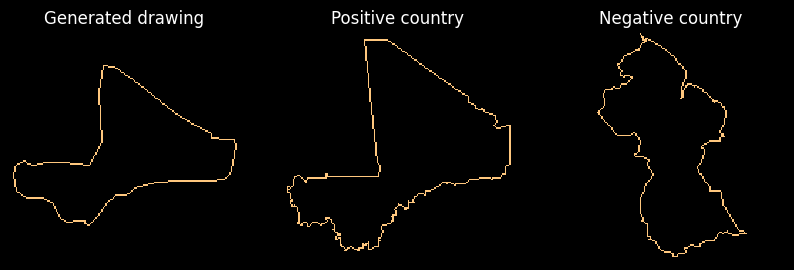

In [53]:
plot_training_sample(train_data)

#### Validation set

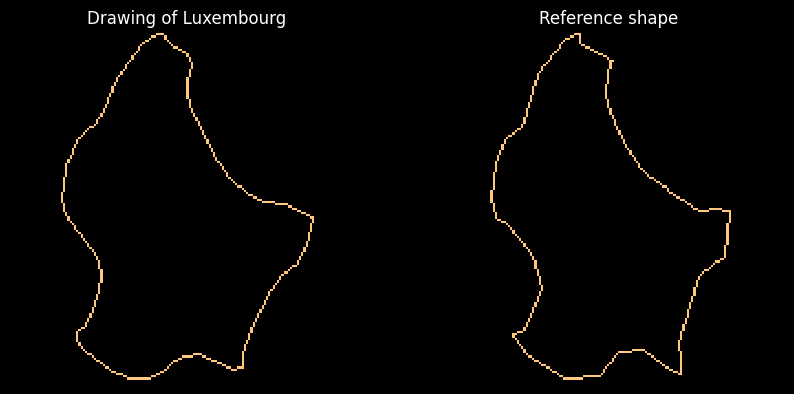

In [54]:
plot_sample(val_data)

#### Test set (user drawings)

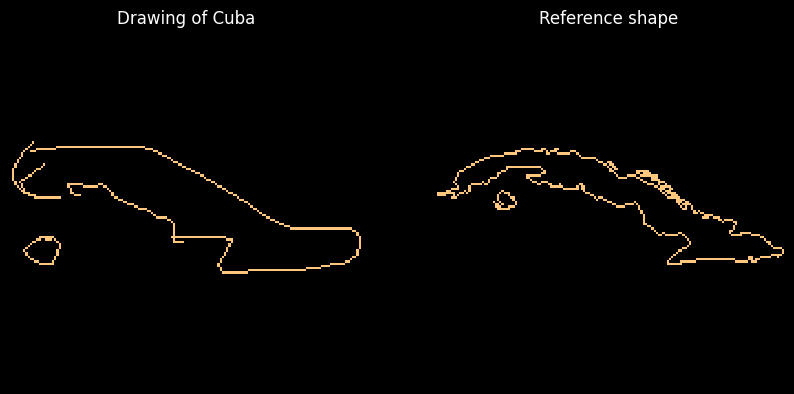

In [55]:
plot_sample(test_data)

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5003`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5003

In [56]:
device = torch.device("mps")

In [93]:
mlflow.set_experiment("triplet")

params = {
    "channels": 16, #4 * random.randint(2, 6),
    "nr_conv_blocks": 4, #random.randint(2, 5),
    "embedding_size": 1024, #128 * random.randint(1, 8),
    "shape": 96, #32 * random.randint(1, 4),
    "learning_rate": random.uniform(0.006, 0.012),
    "margin": 0.8, #random.uniform(0.3, 1.2),
    "temperature": 0.7, #random.uniform(0.4, 1.1),
    "nr_epochs": 16, #random.randint(15, 75),
}

model = TripletModel(CustomEmbeddingModel(**params)).to(device)
params["embedding_model"] = model.embedding_model.__class__.__name__

optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"])
triplet_loss = nn.TripletMarginLoss(margin=params["margin"])

print("\n".join(f"{key}: {value}" for key, value in params.items()))

2025/04/19 11:08:45 INFO mlflow.tracking.fluent: Experiment with name 'triplet' does not exist. Creating a new experiment.


channels: 16
nr_conv_blocks: 4
embedding_size: 1024
shape: 96
learning_rate: 0.010904446988126478
margin: 0.8
temperature: 0.7
nr_epochs: 16
embedding_model: CustomEmbeddingModel


In [94]:
# Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

# Initialise dataloaders
train_dl = DataLoader(train_data, batch_size=24, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=24, num_workers=2)

In [95]:
with mlflow.start_run() as run:
    mlflow.log_params(params)

    # Start training
    for epoch in range(params["nr_epochs"]):
        loss = train(model, train_dl, triplet_loss, optimizer)
        mlflow.log_metric("loss", loss, epoch)
        print(
            "Epoch: {}/{}\t loss: {:.3f}".format(epoch + 1, params["nr_epochs"], loss)
        )

        if (epoch + 1) % 4 == 0:
            _, ranking, _ = evaluate(model, val_dl, ref_data)

            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)

            print(
                "Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t".format(
                    epoch + 1,
                    params["nr_epochs"],
                    np.mean(ranking) + 1,
                    100 * np.mean(ranking < 10),
                    100 * np.mean(ranking < 1),
                )
            )

Epoch: 1/16	 loss: 0.092


Epoch: 2/16	 loss: 0.074


Epoch: 3/16	 loss: 0.032


Epoch: 4/16	 loss: 0.019


Epoch: 4/16	 Average rank: 3.67	 top 10 acc: 95.0%	 top 1 acc: 79.5%	


Epoch: 5/16	 loss: 0.027


Epoch: 6/16	 loss: 0.008


Epoch: 7/16	 loss: 0.023


Epoch: 8/16	 loss: 0.022


Epoch: 8/16	 Average rank: 3.21	 top 10 acc: 95.0%	 top 1 acc: 80.5%	


Epoch: 9/16	 loss: 0.032


Epoch: 10/16	 loss: 0.026


/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/augmentables/polys.py:2474: UserWarning: Encountered exception  during polygon repair in segment intersection computation. Will skip that step.
  ia.warn(
Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x17718c100, s0=(94.3877, 42.36), s1=(94.429, 43.0021), p=(94.429, 43.0021), type=0, slope=15.54721549636547)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/augmentables/polys.py", line 2465, in _gen

Epoch: 11/16	 loss: 0.024


Epoch: 12/16	 loss: 0.011


Epoch: 12/16	 Average rank: 1.94	 top 10 acc: 95.5%	 top 1 acc: 80.5%	


Epoch: 13/16	 loss: 0.013


Epoch: 14/16	 loss: 0.010


/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/augmentables/polys.py:2474: UserWarning: Encountered exception  during polygon repair in segment intersection computation. Will skip that step.
  ia.warn(
Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x3019e4ca0, s0=(84.6775, 26.009), s1=(84.6919, 26.0305), p=(84.6919, 26.0305), type=0, slope=1.4930555555545892)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/venv/lib/python3.12/site-packages/imgaug/augmentables/polys.py", line 2465, in 

Epoch: 15/16	 loss: 0.005


Epoch: 16/16	 loss: 0.000


Epoch: 16/16	 Average rank: 1.71	 top 10 acc: 99.0%	 top 1 acc: 77.0%	


### Evaluate model

In [96]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

INFO:countryguess.data:Loaded 86 samples from ./data/drawings/


In [97]:
country_names, ranking, conf_scores = evaluate(model, test_dl, ref_data)

with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [98]:
print("Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t"
      .format(np.mean(ranking) + 1, 100 * np.mean(ranking < 10), 100 * np.mean(ranking < 1)))

Average rank: 4.55	 top 10 acc: 92.9%	 top 1 acc: 81.2%	


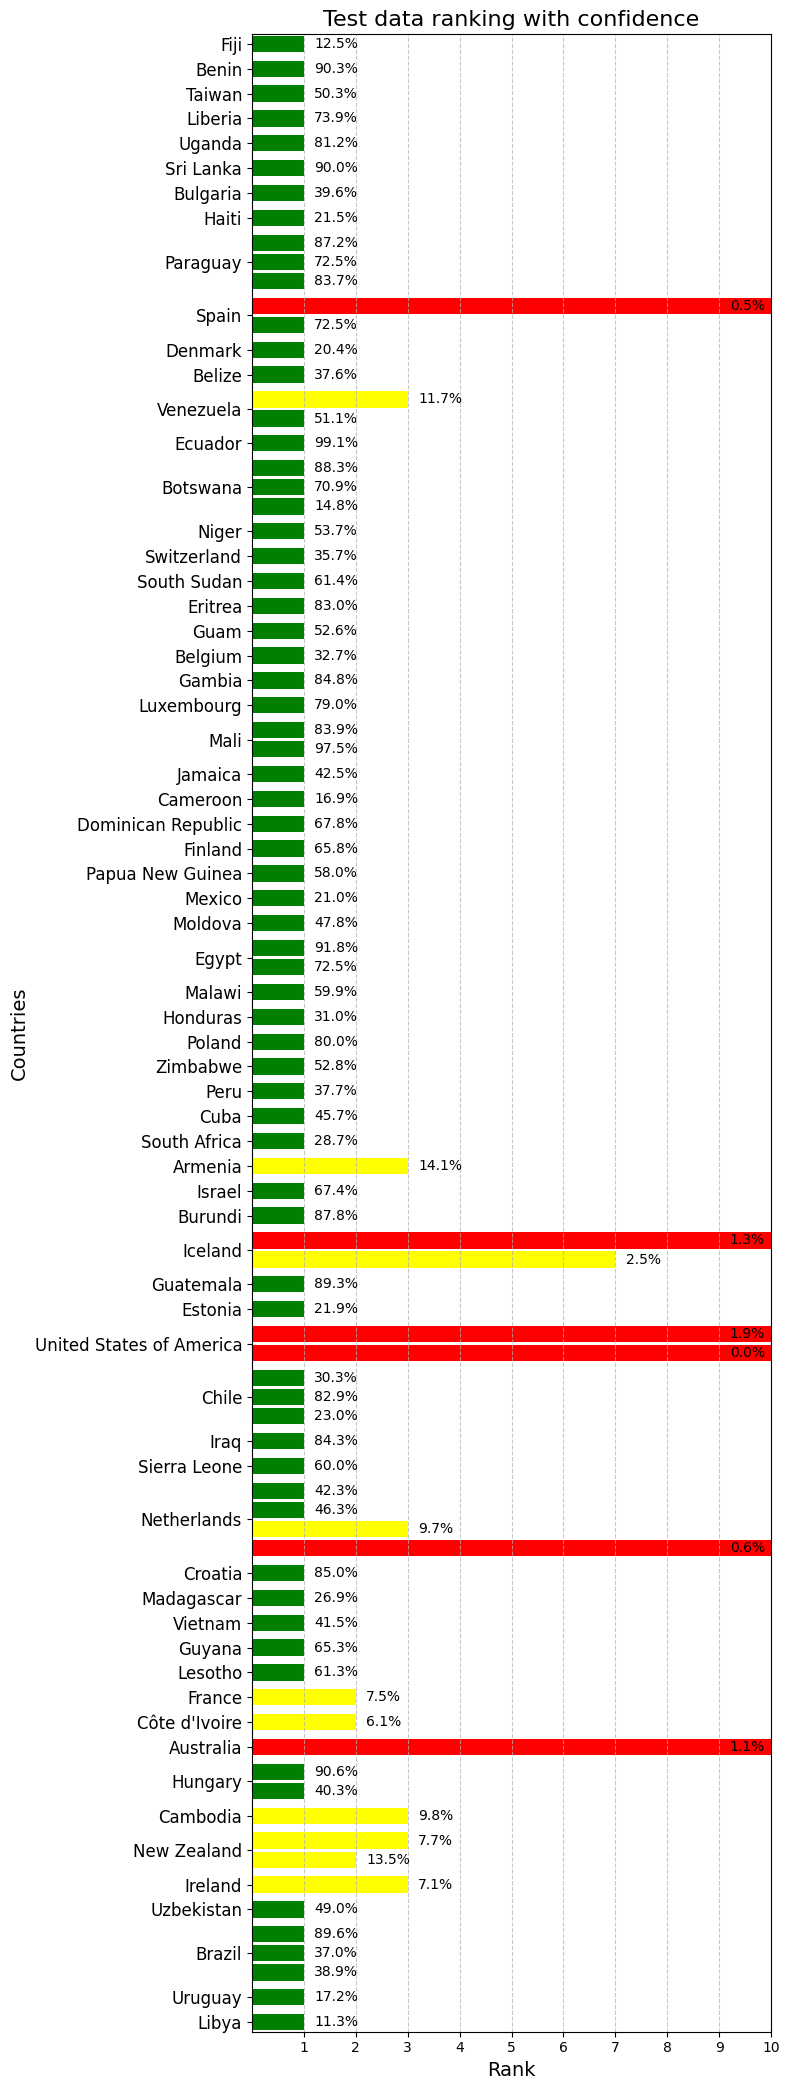

In [99]:
plot_evaluation(country_names, ranking, conf_scores)

### Log model

In [100]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

2025/04/19 11:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Make sure to set promote your desired model to the Model Registry using the MLFlow UI. The model with the champion alias will be used by the ML server.  You can set the name of the model within the docker-compose.yml file or by setting the environment variable MODEL_NAME if you run the app locally.

### Error Analysis
Let's look at the countries for which the model struggles. 

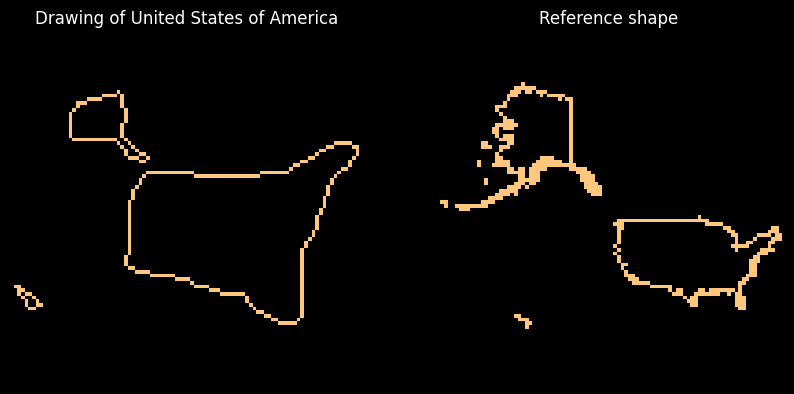

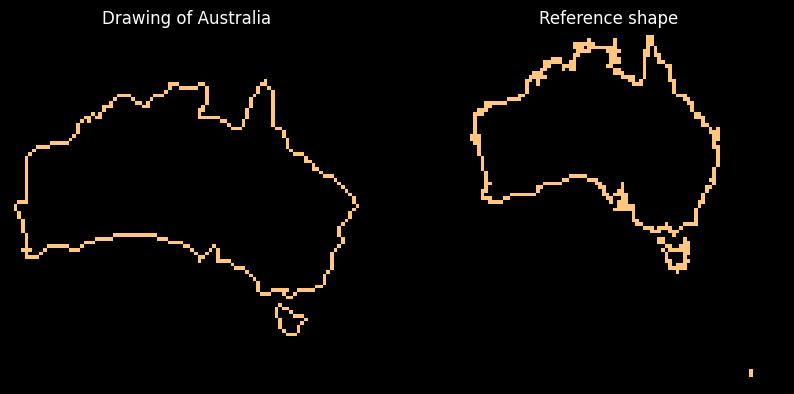

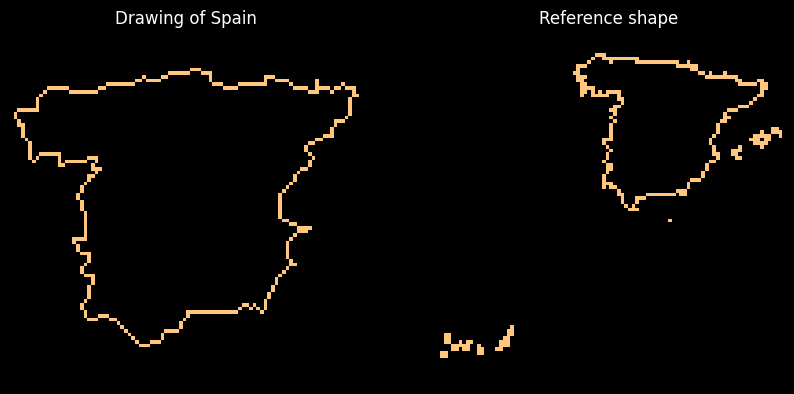

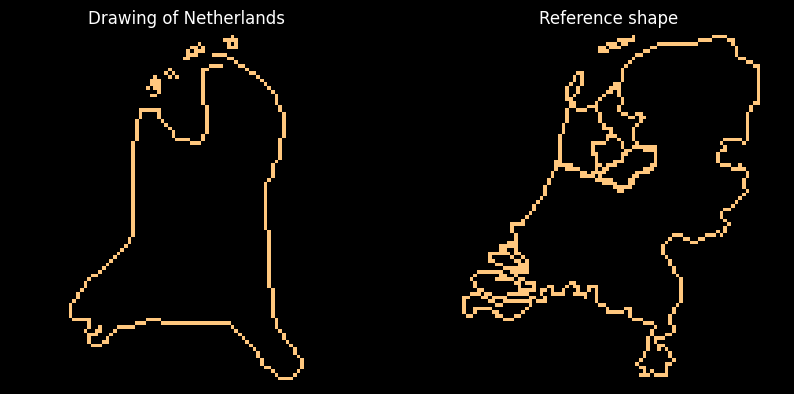

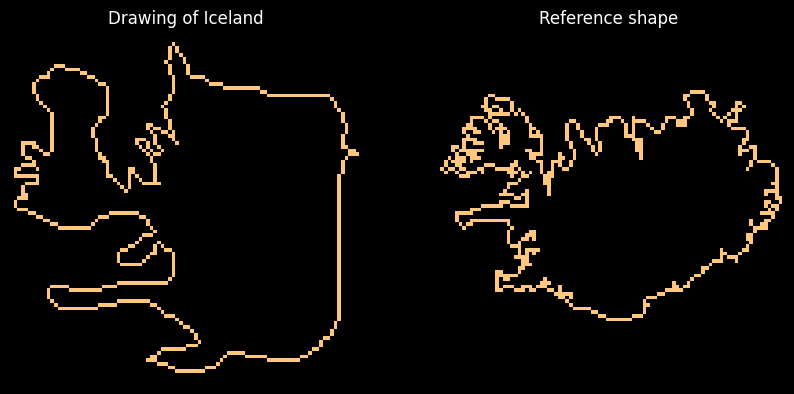

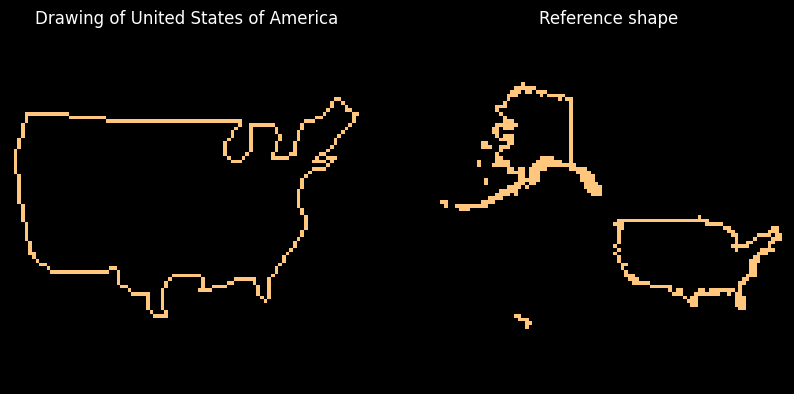

In [101]:
for idx, (rank, score) in enumerate(zip(ranking, conf_scores)):
    if rank>10:
        plot_sample(test_data, idx=idx)